## Example LOB Visualization and Analysis
After reconstructing the limit order book (LOB) from the ITCH5 data, we can visualize the order book and trade data to analyze market dynamics.

In [9]:
import warnings
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

warnings.filterwarnings("ignore")

### Data Loading
To begin, we load the datasets for MSFT's order book history and trade history. The order book data has the market depth at various price levels (for this example we recorded up  50 levels), while the trade data records actual execution of transactions, which includes execution of [hidden/non-displayed orders](https://www.nasdaq.com/solutions/large-in-scale)

In [10]:
# Load the datasets
df_order_book = pd.read_csv("output/MSFT/MSFT_order_book_history.csv")
df_trades = pd.read_csv("output/MSFT/MSFT_trades.csv")

STOCK_NAME = "MSFT"

### Preprocessing the Data
With the datasets loaded, we preprocess the data to facilitate visualization. The original timestamps are in nanoseconds since midnight, . 

In [11]:
df_order_book["time"] = pd.to_datetime(
    df_order_book["timestamp"], unit="ns"
) + pd.DateOffset(years=49, months=0, days=29)

df_trades["time"] = pd.to_datetime(df_trades["timestamp"], unit="ns") + pd.DateOffset(
    years=49, months=0, days=29
)

### Trade Price and Volume
We'll start by plotting the time series of actual trade prices taken from the `MSFT_trades.csv` as well as the volume of shares traded in intervals of approximately 5 minutes (note: the scale for volume is logarithmic); if you're curious, that big drop after hours is because [Microsoft's revenue missed Wall Street's projections](https://www.cnn.com/2019/01/30/tech/microsoft-earnings/index.html). 

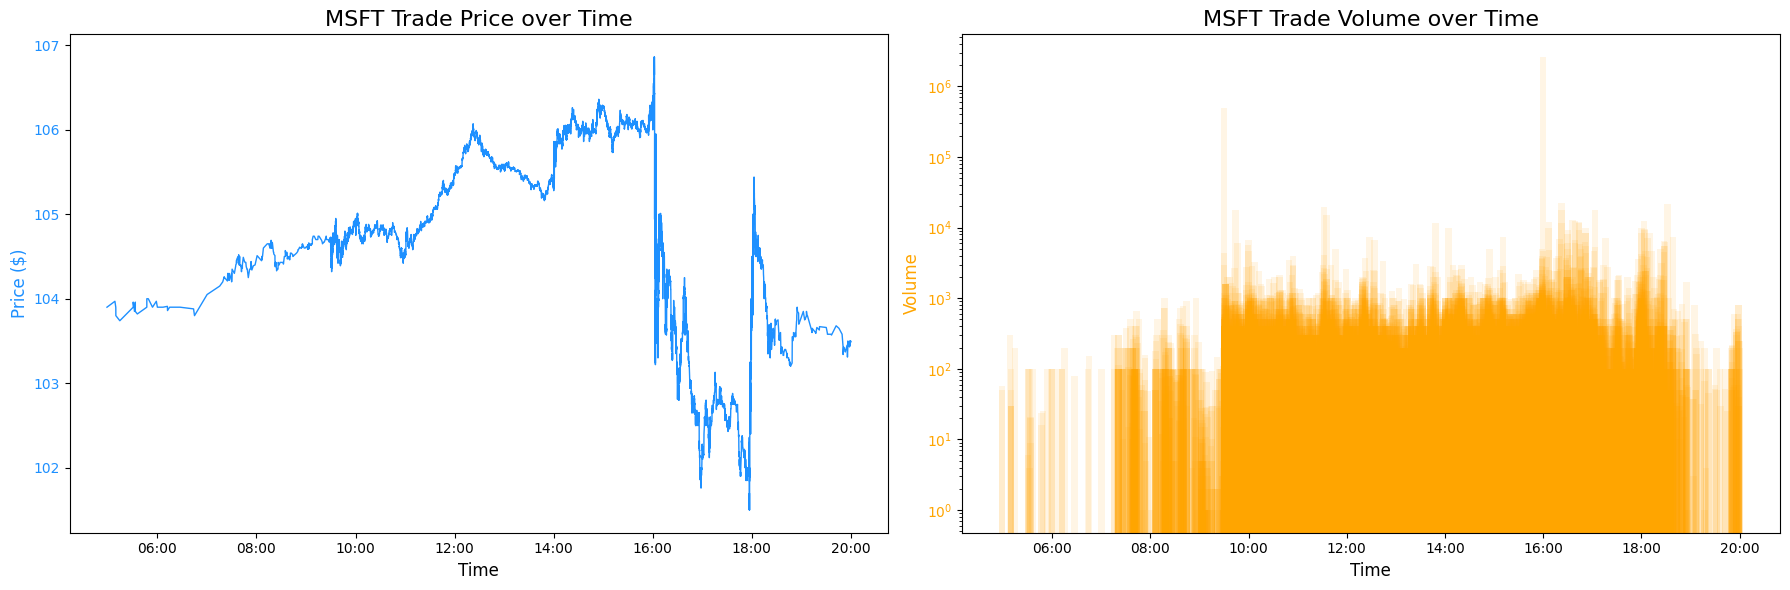

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
color = ["dodgerblue", "orange"]
HH_MM = DateFormatter("%H:%M")

# Plot for trade prices
ax1.plot(df_trades["time"], df_trades["prices"], color=color[0], lw=1)
ax1.set_xlabel("Time", fontsize=12)
ax1.xaxis.set_major_formatter(HH_MM)
ax1.set_ylabel("Price ($)", fontsize=12, color=color[0])
ax1.tick_params(axis="y", labelcolor=color[0])
ax1.set_title(f"{STOCK_NAME} Trade Price over Time", fontsize=16)

# Plot for trade volume (width is approximately 5 minutes)
ax2.bar(
    df_trades["time"], df_trades["shares"], color=color[1], alpha=0.1, width=0.00556
)
ax2.set_xlabel("Time", fontsize=12)
ax2.xaxis.set_major_formatter(HH_MM)
ax2.set_ylabel("Volume", fontsize=12, color=color[1])
ax2.tick_params(axis="y", labelcolor=color[1])
ax2.set_yscale("log")
ax2.set_title(f"{STOCK_NAME} Trade Volume over Time", fontsize=16)

fig.tight_layout()
plt.show()

### Volume Weighted Average Price (VWAP)

We will now compute the Volume Weighted Average Price (VWAP), defined as:
$$
\text{VWAP} = \frac{\sum (Price \times Volume)}{\sum (Volume)}
$$
over a given period. VWAP serves as a trading benchmark that provides insight into the average price at which a security is traded relative to its volume over a specified time frame. The VWAP is particularly useful as it reflects both the price levels and the relative size of market trades; i.e it reflects the price at which the average share was traded over the day. We will use a period of 5 minutes.

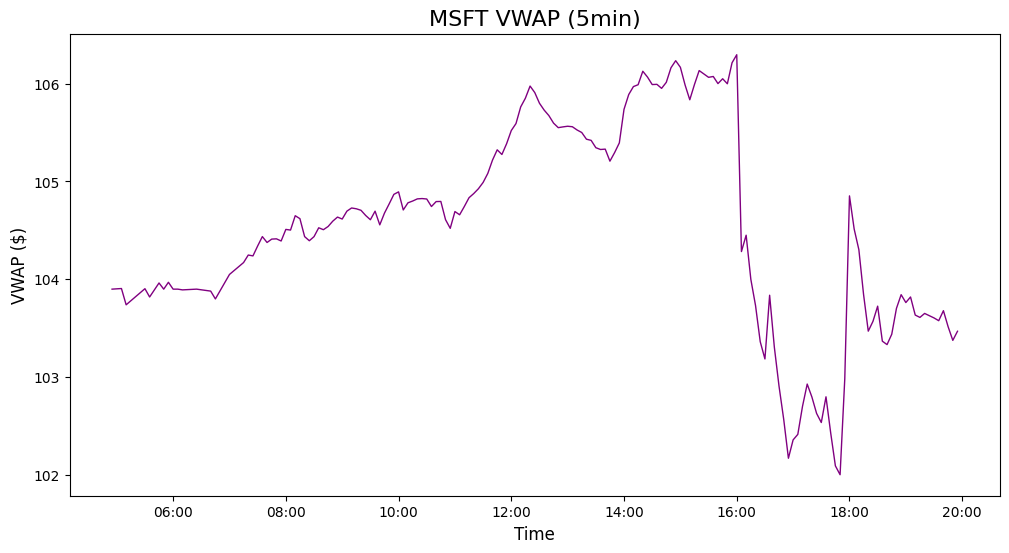

In [13]:
# Resampling data at 5 minutes and calculating VWAP
df_vwap_5min = df_trades.resample("5T", on="time").apply(
    lambda x: (x.prices * x.shares).sum() / x.shares.sum()
    if x.shares.sum() > 0
    else None
)

# Removing any NaN values
df_vwap_5min.dropna(inplace=True)

# Plotting VWAP per 5 minutes
plt.figure(figsize=(12, 6))
plt.plot(df_vwap_5min.index, df_vwap_5min, color="purple", lw=1)
plt.title(f"{STOCK_NAME} VWAP (5min)", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.gca().xaxis.set_major_formatter(HH_MM)
plt.ylabel("VWAP ($)", fontsize=12)
plt.show()

### Limit Order Book (LOB) Depth Snapshot

Next we'll plot the cumulative volume for both buy orders (bids) and sell orders (asks) across various price levels; this gives us a snapshot of the market's liquidity and order distribution at a specific moment––given by `SNAPSHOT_TIME`. In this case below it's right around the time 

In [14]:
print(
    f"Make sure snapshot_time is in [ {df_order_book['time'].min()}, {df_order_book['time'].max()} ]"
)

Make sure snapshot_time is in [ 2019-01-30 04:00:00.028323023, 2019-01-30 20:00:00.072699031 ]


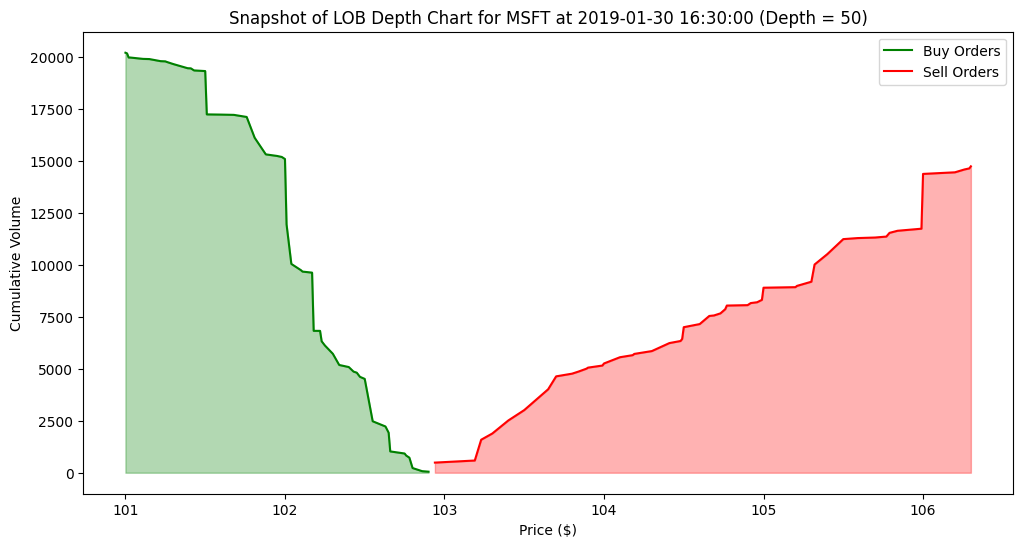

In [15]:
NUM_LEVELS = 50
SNAPSHOT_TIME = pd.to_datetime("2019-01-30 16:30:00")
snapshot = df_order_book.set_index("time").asof(pd.to_datetime(SNAPSHOT_TIME)).dropna()

# Extracting buy/sell prices and shares
buy_prices = snapshot.filter(regex="buy_price_").values.flatten()
buy_shares = snapshot.filter(regex="buy_shares_").values.flatten()
sell_prices = snapshot.filter(regex="sell_price_").values.flatten()
sell_shares = snapshot.filter(regex="sell_shares_").values.flatten()

# Calculate the cumulative depth for buy and sell orders
cumulative_buy = buy_shares.cumsum()
cumulative_sell = sell_shares.cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(buy_prices, cumulative_buy, color="green", label="Buy Orders")
plt.plot(sell_prices, cumulative_sell, color="red", label="Sell Orders")
plt.fill_between(buy_prices, 0, cumulative_buy, color="green", alpha=0.3)
plt.fill_between(sell_prices, 0, cumulative_sell, color="red", alpha=0.3)
plt.title(
    f"Snapshot of LOB Depth Chart for {STOCK_NAME} at {SNAPSHOT_TIME} (Depth = {NUM_LEVELS})"
)
plt.xlabel("Price ($)")
plt.ylabel("Cumulative Volume")
plt.legend()
plt.show()

### Intraday LOB Depth
For a closer look at the market's structure throughout the trading day, we resample MSFT's limit order book at one-minute intervals, and remove outliers. The chart displays the bid and ask at different price levels throughout the day, the gradient representing the depth of the price level. 


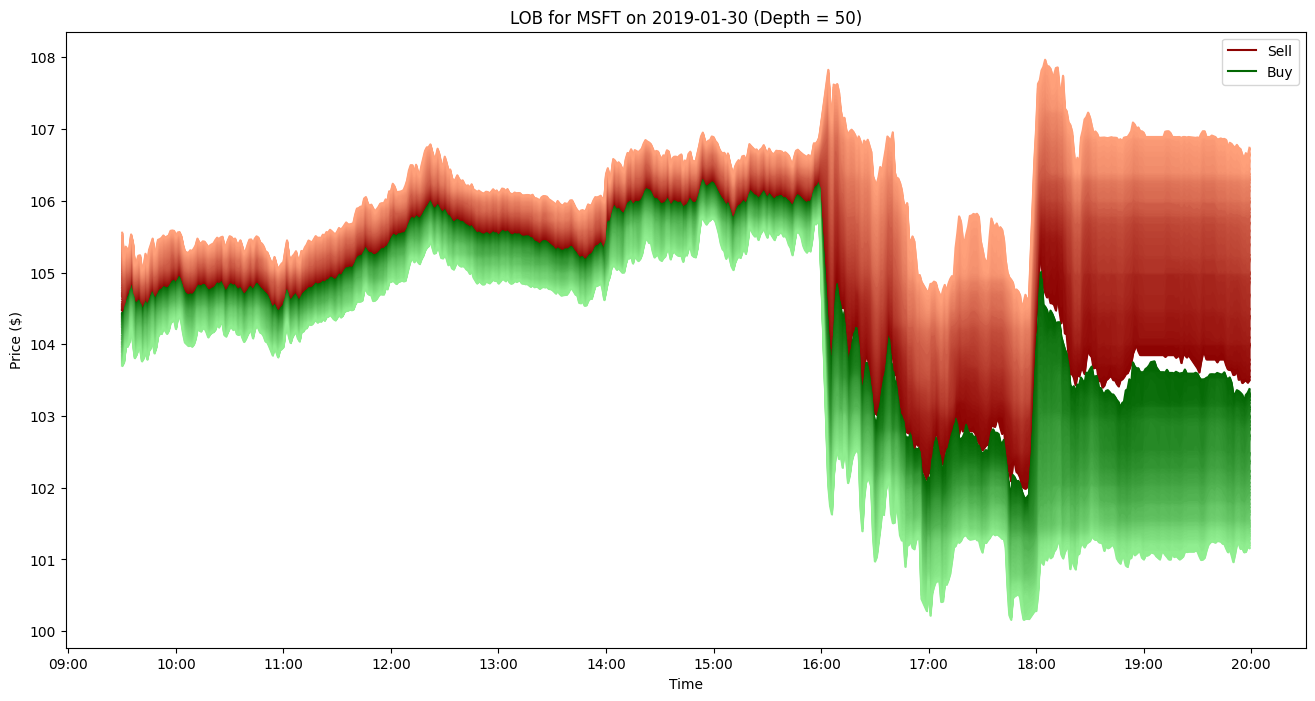

In [16]:
# Resample data to 1 minute intervals
df_resampled = df_order_book.resample("1T", on="time").mean().dropna().reset_index()

# Remove outliers
sell_upper_bound = (
    df_resampled[[f"sell_price_{i}" for i in range(1, NUM_LEVELS + 1)]]
    .quantile(0.99)
    .max()
)
buy_lower_bound = (
    df_resampled[[f"buy_price_{i}" for i in range(1, NUM_LEVELS + 1)]]
    .quantile(0.01)
    .min()
)

df_resampled = df_resampled[
    (
        df_resampled[[f"sell_price_{i}" for i in range(1, NUM_LEVELS + 1)]]
        <= sell_upper_bound
    ).all(axis=1)
    & (
        df_resampled[[f"buy_price_{i}" for i in range(1, NUM_LEVELS + 1)]]
        >= buy_lower_bound
    ).all(axis=1)
]

# Plotting
plt.figure(figsize=(16, 8))
# Define color maps for gradients
cmap_buy = mcolors.LinearSegmentedColormap.from_list(
    "buy_gradient", ["darkgreen", "lightgreen"], N=NUM_LEVELS
)
cmap_sell = mcolors.LinearSegmentedColormap.from_list(
    "sell_gradient", ["darkred", "lightsalmon"], N=NUM_LEVELS
)

# Plot each level with gradient
for i in range(1, NUM_LEVELS + 1):
    plt.plot(
        df_resampled["time"],
        df_resampled[f"sell_price_{i}"],
        color=cmap_sell(i / NUM_LEVELS),
        label="Sell" if i == 1 else "",
    )
    plt.plot(
        df_resampled["time"],
        df_resampled[f"buy_price_{i}"],
        color=cmap_buy(i / NUM_LEVELS),
        label="Buy" if i == 1 else "",
    )

for i in range(1, NUM_LEVELS):
    plt.fill_between(
        df_resampled["time"],
        df_resampled[f"sell_price_{i}"],
        df_resampled[f"sell_price_{i+1}"],
        color=cmap_sell(i / NUM_LEVELS),
    )
    plt.fill_between(
        df_resampled["time"],
        df_resampled[f"buy_price_{i}"],
        df_resampled[f"buy_price_{i+1}"],
        color=cmap_buy(i / NUM_LEVELS),
    )

DAY_TODAY = pd.to_datetime("2019-01-30 16:30:00").strftime("%Y-%m-%d")
plt.title(f"LOB for {STOCK_NAME} on {DAY_TODAY} (Depth = {NUM_LEVELS})")
plt.xlabel("Time")
plt.gca().xaxis.set_major_formatter(HH_MM)
plt.ylabel("Price ($)")
plt.legend(loc="upper right")
plt.show()